# Zadanie 3 - Klasyfikacja tekstur
Miłosz Sadziński 259139

W celu wykonania zadania wykonane zostały wielokrotnie zdjęcia różnych powierzchni płaskich:
Drzwi, Ściany, Paneli, Tynku.
Wykonane zdjęcia zostały umieszczone w folderze Próbki, a następnie przygotowany został i uruchomiony skrypt służący do podzielenia zdjęć na fragmenty o zadanym rozmiarze, po czym próbki były przekształcone do skali szarości a także została zmniejszona ich głębia jasności do 5 bitów. Na koniec próbki zostały zapisane do folderów.
Uwaga: skrypty zostały przygotowane i testowane w IDE PyCharm i to tam skrypty te będą wyglądały najlepiej ( tj. pasek postępu, który w przypadku tego zadania bardzo się przydał do wizualizacji postępu pracy skryptów wraz z estymacją tego ile jeszcze będzie trwało jego wykonywanie).

In [5]:
import os
from PIL import Image
from tqdm import tqdm

# Parametry
patch_size = 128  # Rozmiar wycinków
supported_extensions = (".png", ".jpg", ".jpeg", ".bmp", ".tiff")

def process_patch(patch):
    # Konwersja do skali szarości
    gray = patch.convert("L")
    # Redukcja do 5-bitowej jasności
    reduced = gray.point(lambda x: int(x / 4) * 4)
    return reduced

def slice_image(image_path, output_subfolder, patch_size):
    image = Image.open(image_path)
    img_width, img_height = image.size
    basename = os.path.splitext(os.path.basename(image_path))[0]

    os.makedirs(output_subfolder, exist_ok=True)

    num_x = img_width // patch_size
    num_y = img_height // patch_size
    total_patches = num_x * num_y

    patch_id = 0
    with tqdm(total=total_patches, desc=f"Przetwarzanie {basename}", unit="patch", position=1, leave=False) as pbar:
        for y in range(0, img_height, patch_size):
            for x in range(0, img_width, patch_size):
                box = (x, y, x + patch_size, y + patch_size)
                patch = image.crop(box)

                if patch.size[0] == patch_size and patch.size[1] == patch_size:
                    processed_patch = process_patch(patch)
                    patch_filename = f"{basename}_patch_{patch_id}.png"
                    patch_path = os.path.join(output_subfolder, patch_filename)
                    processed_patch.save(patch_path)
                    patch_id += 1
                    pbar.update(1)

def process_all_images(file_path, patch_size):
    images = [f for f in os.listdir(file_path) if f.lower().endswith(supported_extensions)]
    if not images:
        print("Brak obsługiwanych zdjęć w podanym folderze.")
        return

    for filename in tqdm(images, desc="Przetwarzanie zdjęć", position=0, leave=False):
        if filename.lower().endswith(supported_extensions):
            image_path = os.path.join(file_path, filename)
            basename = os.path.splitext(filename)[0]
            output_subfolder = os.path.join(file_path, basename)
            slice_image(image_path, output_subfolder, patch_size)

# Uruchomienie
file_path = input("Podaj ścieżkę do folderu ze zdjęciami: ")
process_all_images(file_path, patch_size)


Podaj ścieżkę do folderu ze zdjęciami:  C:\Users\iksni\PycharmProjects\PythonProject\Próbki


Przetwarzanie drzwi_1:  99%|█████████▉| 2935/2961 [00:09<00:00, 331.10patch/s]
Przetwarzanie drzwi_1: 2969patch [00:09, 333.69patch/s]                       
Przetwarzanie drzwi_1: 3003patch [00:09, 324.02patch/s]
Przetwarzanie drzwi_1: 3041patch [00:09, 340.23patch/s]
Przetwarzanie drzwi_2:  99%|█████████▉| 2940/2961 [00:10<00:00, 265.67patch/s]
Przetwarzanie drzwi_2: 2967patch [00:10, 247.82patch/s]                       
Przetwarzanie drzwi_2: 2998patch [00:10, 262.85patch/s]
Przetwarzanie drzwi_2: 3029patch [00:11, 275.07patch/s]
Przetwarzanie drzwi_2: 3061patch [00:11, 287.82patch/s]
Przetwarzanie drzwi_3: 100%|█████████▉| 2955/2961 [00:09<00:00, 273.74patch/s]
Przetwarzanie drzwi_3: 2983patch [00:10, 270.52patch/s]                       
Przetwarzanie drzwi_3: 3011patch [00:10, 271.50patch/s]
Przetwarzanie drzwi_3: 3043patch [00:10, 285.46patch/s]
Przetwarzanie drzwi_4:  99%|█████████▉| 2942/2961 [00:11<00:00, 312.65patch/s]
Przetwarzanie drzwi_4: 2974patch [00:11, 311.98patch/s]

Tak przygotowane próbki zostały poddane obliczeniom używając modelu macierzy zdarzeń z pakietu scikit-image. 
Należało wyznaczyć następujące cechy:
a. dissimilarity, correlation, contrast, energy, homogeneity, ASM.
b. Przyjąć 3 odległości pikseli: 1, 3, 5
c. oraz 4 kierunki: 0, 45, 90 I 135 stopni (zakładamy symetrię kierunków).
d. Każdy wektor cech uzupełnić o nazwę kategorii tekstury


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from skimage import io
from skimage.feature import graycomatrix, graycoprops
from tqdm import tqdm

# Parametry GLCM
distances = [1, 3, 5]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
props = ['dissimilarity', 'correlation', 'contrast', 'energy', 'homogeneity', 'ASM']

# Wczytanie i przetworzenie jednej próbki
def extract_features(image_path, distances, angles):
    image = io.imread(image_path)
    image = (image * 255).astype(np.uint8)  # skala 0–255

    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    feature_vector = []
    for prop in props:
        values = graycoprops(glcm, prop)
        feature_vector.extend(values.flatten())  # wartości w kolejności: d0a0, d0a1, d0a2, ..., d2a3
    return feature_vector

# Przejście po wszystkich obrazach w podfolderach
def process_texture_dataset(dataset_folder, max_samples_per_class):
    rows = []

    categories = [d for d in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, d))]
    for category in tqdm(categories, desc="Foldery", position=0):  # pasek postępu dla folderów
        category_path = os.path.join(dataset_folder, category)
        if not os.path.isdir(category_path):
            continue

        all_files = [f for f in os.listdir(category_path)
            if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff"))]
        selected_files = random.sample(all_files, min(len(all_files), max_samples_per_class))

        with tqdm(selected_files, desc=f"{category}", position=1, leave=False) as bar:
            for filename in bar:
                filepath = os.path.join(category_path, filename)
                bar.set_postfix_str(f"{filename}")
                features = extract_features(filepath, distances, angles)
                features.append(category)
                rows.append(features)
    return rows

# Nagłówki kolumn
def create_headers():
    headers = []
    for prop in props:
        for d in distances:
            for a_deg in [0, 45, 90, 135]:
                headers.append(f"{prop}_d{d}_a{a_deg}")
    headers.append("category")
    return headers

# Uruchomienie
if __name__ == "__main__":
    dataset_folder = input("Podaj ścieżkę do folderu z kategoriami tekstur: ").strip()
    max_samples_per_class = int(input("Podaj liczbę próbek do przetworzenia na kategorię: "))
    data = process_texture_dataset(dataset_folder, max_samples_per_class)
    headers = create_headers()
    df = pd.DataFrame(data, columns=headers)
    df.to_csv("wektory_" + str(max_samples_per_class) + ".csv", index=False)
    print("Zapisano wektory cech do wektory_" + str(max_samples_per_class) + ".csv")


Podaj ścieżkę do folderu z kategoriami tekstur:  Próbki
Podaj liczbę próbek do przetworzenia na kategorię:  512


panele_1:  35%|███▍      | 177/512 [00:17<00:31, 10.47it/s, panele_1_patch_1358.png]

ściana_1:  86%|████████▌ | 440/512 [00:43<00:07, 10.02it/s, ściana_1_patch_150.png]

Próbki użyte do wygenerowania wektora cech są wybierane losowo tak aby wykorzystywać cały zakres dostępnych próbek.
Ostatnim krokiem było napisać skrypt do klasyfikacji wektorów cech z wykorzystaniem dowolnego algorytmu klasyfikacji danych 
dostępnego w pakiecie scikit-learn. Następnie należało przeprowadzić uczenie na zbiorze treningowym, a testowanie na zbiorze testowym. Na koniec wyświetlić dokładność klasyfikatora.


Podaj ścieżkę do pliku z wektorami cech:  wektory_512.csv


Dokładność klasyfikatora wynosi: 0.38527284681130836

[[0.23863636 0.01704545 0.05113636 0.63068182 0.         0.
  0.         0.         0.         0.         0.00568182 0.
  0.         0.         0.         0.01704545 0.         0.03977273]
 [0.01156069 0.0867052  0.08092486 0.78034682 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.01156069 0.         0.02890173]
 [0.04093567 0.06432749 0.12865497 0.71345029 0.         0.
  0.         0.         0.         0.         0.         0.
  0.00584795 0.         0.         0.00584795 0.         0.04093567]
 [0.01123596 0.01685393 0.05617978 0.87640449 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.02247191 0.         0.01685393]
 [0.         0.         0.         0.33727811 0.35502959 0.07692308
  0.17751479 0.         0.         0.         0.         0.01183432
  0.         0.01183432 0.0295858  0.         0.      

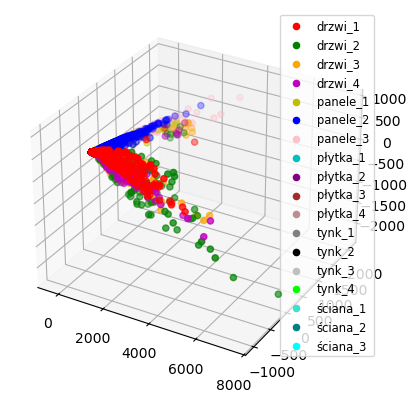

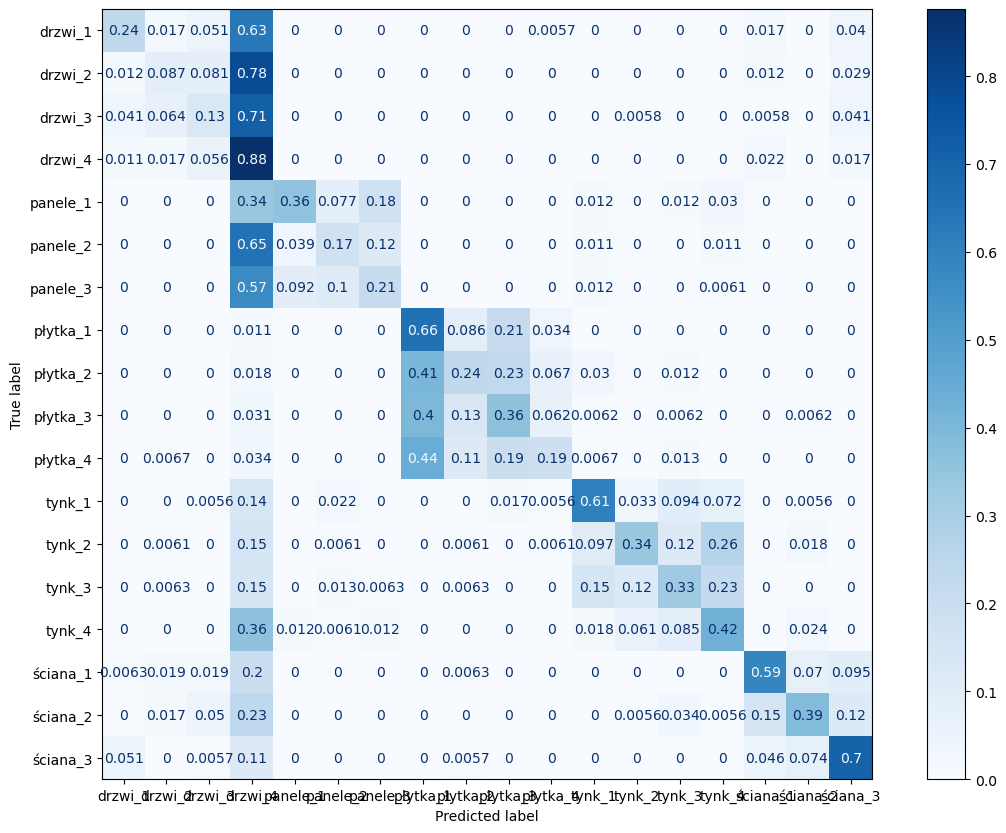

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

dataset = input("Podaj ścieżkę do pliku z wektorami cech: ").strip()
features = pd.read_csv(dataset, sep=',')

data = np.array(features)
X = (data[:,:-1]).astype('float64') # dane wejściowe
Y = data[:,-1] # etykiety klas

x_transform = PCA(n_components=3) # transformowanie danych do przestrzeni trójwymiarowej

Xt = x_transform.fit_transform(X)

red = Y == 'drzwi_1'
green = Y == 'drzwi_2'
orange = Y == 'drzwi_3'
magenta = Y == 'drzwi_4'
yellow = Y == 'panele_1'
blue = Y == 'panele_2'
pink = Y == 'panele_3'
cyan = Y == 'płytka_1'
purple = Y == 'płytka_2'
brown = Y == 'płytka_3'
rose = Y == 'płytka_4'
grey = Y == 'tynk_1'
black = Y == 'tynk_2'
silver = Y == 'tynk_3'
emerald = Y == 'tynk_4'
turquoise = Y == 'ściana_1'
teal = Y == 'ściana_2'
aqua = Y == 'ściana_3'

fig = plt.figure()
fig_cm, ax_cm = plt.subplots(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xt[red, 0], Xt[red, 1], Xt[red, 2], c="r", label="drzwi_1")
ax.scatter(Xt[green, 0], Xt[green, 1], Xt[green, 2], c="g", label="drzwi_2")
ax.scatter(Xt[orange, 0], Xt[orange, 1], Xt[orange, 2], c="orange", label="drzwi_3")
ax.scatter(Xt[magenta, 0], Xt[magenta, 1], Xt[magenta, 2], c="m", label="drzwi_4")
ax.scatter(Xt[yellow, 0], Xt[yellow, 1], Xt[yellow, 2], c="y", label="panele_1")
ax.scatter(Xt[blue, 0], Xt[blue, 1], Xt[blue, 2], c="b", label="panele_2")
ax.scatter(Xt[pink, 0], Xt[pink, 1], Xt[pink, 2], c="pink", label="panele_3")
ax.scatter(Xt[cyan, 0], Xt[cyan, 1], Xt[cyan, 2], c="c", label="płytka_1")
ax.scatter(Xt[purple, 0], Xt[purple, 1], Xt[purple, 2], c="purple", label="płytka_2")
ax.scatter(Xt[brown, 0], Xt[brown, 1], Xt[brown, 2], c="brown", label="płytka_3")
ax.scatter(Xt[rose, 0], Xt[rose, 1], Xt[rose, 2], c="rosybrown", label="płytka_4")
ax.scatter(Xt[grey, 0], Xt[grey, 1], Xt[grey, 2], c="grey", label="tynk_1")
ax.scatter(Xt[black, 0], Xt[black, 1], Xt[black, 2], c="black", label="tynk_2")
ax.scatter(Xt[silver, 0], Xt[silver, 1], Xt[silver, 2], c="silver", label="tynk_3")
ax.scatter(Xt[emerald, 0], Xt[emerald, 1], Xt[emerald, 2], c="lime", label="tynk_4")
ax.scatter(Xt[turquoise, 0], Xt[turquoise, 1], Xt[turquoise, 2], c="turquoise", label="ściana_1")
ax.scatter(Xt[teal, 0], Xt[teal, 1], Xt[teal, 2], c="teal", label="ściana_2")
ax.scatter(Xt[aqua, 0], Xt[aqua, 1], Xt[aqua, 2], c="aqua", label="ściana_3")

ax.legend(loc='upper right', fontsize='small')

classifier = svm.SVC(gamma='auto') # klasyfikator SVM

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # dane podzielone są na 
# zbiór treningowy (1/3) i zbiór testowy (2/3)

classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikatora wynosi: " + str(acc) + "\n")

cm = confusion_matrix(y_test, y_pred, normalize='true')

print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['drzwi_1','drzwi_2','drzwi_3','drzwi_4','panele_1',
                                                                   'panele_2','panele_3','płytka_1','płytka_2',
                                                                   'płytka_3','płytka_4','tynk_1','tynk_2','tynk_3',
                                                                   'tynk_4','ściana_1','ściana_2','ściana_3'])
disp.plot(cmap='Blues', ax=ax_cm)
plt.show()



Na powyższych wykresach znajdują się wyniki 18 zdjęć różnych powierzchni podzielonych na próbki o rozmiarze 128x128. Dokładność klasyfikatora została określona na 0.385, co jest wartością niską. Na pierwszym wykresie można zauważyć, że próbki klasy drzwi znajdują się w swoim sąsiedztwie, podobnie wygląda sprawa jeśli chodzi o panele. Drugi wykres przedstawia wynik klasyfikacji w macierzy pomyłek. Można zauważyć, że bardzo dobrze rozpoznana została klasa drzwi_4, płytka_1, tynk_1, ściana_1 i ściana_3. Natomiast dla drzwi_1 - drzwi_3 doszło do dużej ilości pomyłek, podobnie w przypadku płytka_2 - płytka_4. Oznacza to, że algorytm zidentyfikował te próbki jako podobne, co właściwie jest prawdą (np. uznał drzwi_1 - drzwi_3 jako drzwi_4). Prawdopodobnie zgrupowanie próbek podobnych poprawiłoby wyniki.